In [107]:
import pandas as  pd
from scipy import stats
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

In [108]:
data = pd.read_csv('Matlab\eeglab2020_0\events.csv')
data.head()

,eventnumber,blocksequencenumber,isteststim,object,objectnumber,presentationnumber,sequencenumber,stim,stimnumber,teststimnumber,withinsequencenumber,istarget,stimname,response,rt,correct,time_stimon,time_stimoff,stimdur
0,0,0,0,rice,1309,0,0,stimuli\rice\rice_10s.jpg,9,-1,0,0,rice_10s.jpg,0.0,0.0,0.0,337.411972,337.461950,0.049978
1,1,0,0,kangaroo,862,1,0,stimuli\kangaroo\kangaroo_08s.jpg,7,-1,0,0,kangaroo_08s.jpg,0.0,0.0,0.0,337.511979,337.561951,0.049972
2,2,0,0,kneepad,878,2,0,stimuli\kneepad\kneepad_11s.jpg,10,-1,0,0,kneepad_11s.jpg,0.0,0.0,0.0,337.611975,337.661949,0.049974
3,3,0,0,steamroller,1545,3,0,stimuli\steamroller\steamroller_05n.jpg,4,-1,0,0,steamroller_05n.jpg,0.0,0.0,0.0,337.711996,337.761959,0.049963
4,4,0,0,snowmobile,1483,4,0,stimuli\snowmobile\snowmobile_02s.jpg,1,-1,0,0,snowmobile_02s.jpg,0.0,0.0,0.0,337.811978,337.861943,0.049965


In [109]:
mat = scipy.io.loadmat('Matlab\eeglab2020_0\data.mat')
data_signal = mat['data']

In [110]:
dog_index = data[data['object']=='dog'].index
chair_index = data[data['object']=='face'].index
face_index = data[data['object']=='chair'].index

In [131]:
len(np.linspace(-100, 1000, 275)[69:82])

13

In [116]:
dog = data_signal[:,69:82,dog_index]
chair = data_signal[:,69:82,chair_index]
face = data_signal[:,69:82,face_index]


In [124]:
data_signal.shape

(64, 275, 24648)

In [120]:
dog_mean = np.mean(dog, axis=1)
chair_mean = np.mean(chair, axis=1)
face_mean = np.mean(face, axis=1)

In [121]:
RDMs = np.zeros((3, 3, 64));
for i in range(64):
    X = [face_mean[i,:],chair_mean[i,:], dog_mean[i,:]]
    RDMs[:, :, i] = stats.spearmanr(X, axis=1)[0]

In [139]:
RSA_face = np.zeros((275, 12))
RSA_chair = np.zeros((275, 12))
RSA_dog = np.zeros((275, 12))

for k in range(12):
    index =  np.random.choice(12, size=8, replace=False)
    for i in range(275):
        if i < 263:
            dog = data_signal[:,i: 13+i, dog_index[index]]
            chair = data_signal[:,i: 13+i, chair_index[index]]
            face = data_signal[:,i: 13+i, face_index[index]]
        else:
            dog = data_signal[:,i: 275, dog_index[index]]
            chair = data_signal[:,i: 275, chair_index[index]]
            face = data_signal[:,i: 275, face_index[index]]
            
        dog= np.mean(dog, axis=1)
        dog= np.mean(dog, axis=1)
        dog = dog.reshape(-1,1)
        
        chair= np.mean(chair, axis=1)
        chair= np.mean(chair, axis=1)
        chair = chair.reshape(-1,1)
        
        face= np.mean(face, axis=1)
        face= np.mean(face, axis=1)
        face = face.reshape(-1,1)
        
        no_dog = (face + chair) / 2;
        no_face = (dog + chair) / 2;
        no_chair = (dog + face) / 2;
        
        RDMs_1 = stats.spearmanr(dog, no_dog)[0]
        RDMs_2 = stats.spearmanr(face, no_face)[0]
        RDMs_3 = stats.spearmanr(chair, no_chair)[0]
        
        RSA_face[i, k] = RDMs_1
        RSA_chair[i, k] = RDMs_2
        RSA_dog[i, k] = RDMs_3
        

MRSA_face = np.mean(RSA_face, 1)
SRSA_face = np.std(RSA_face, 1)
con_face_plus = MRSA_face + 0.5 * SRSA_face
con_face_minus = MRSA_face - 0.5 * SRSA_face

MRSA_chair = np.mean(RSA_chair, 1)
SRSA_chair = np.std(RSA_chair,1)
con_chair_plus = MRSA_chair + 0.5 * SRSA_chair
con_chair_minus = MRSA_chair - 0.5 * SRSA_chair

MRSA_dog = np.mean(RSA_dog, 1)
SRSA_dog = np.std(RSA_dog, 1)
con_dog_plus = MRSA_dog +1 * SRSA_dog
con_dog_minus = MRSA_dog - 1 * SRSA_dog


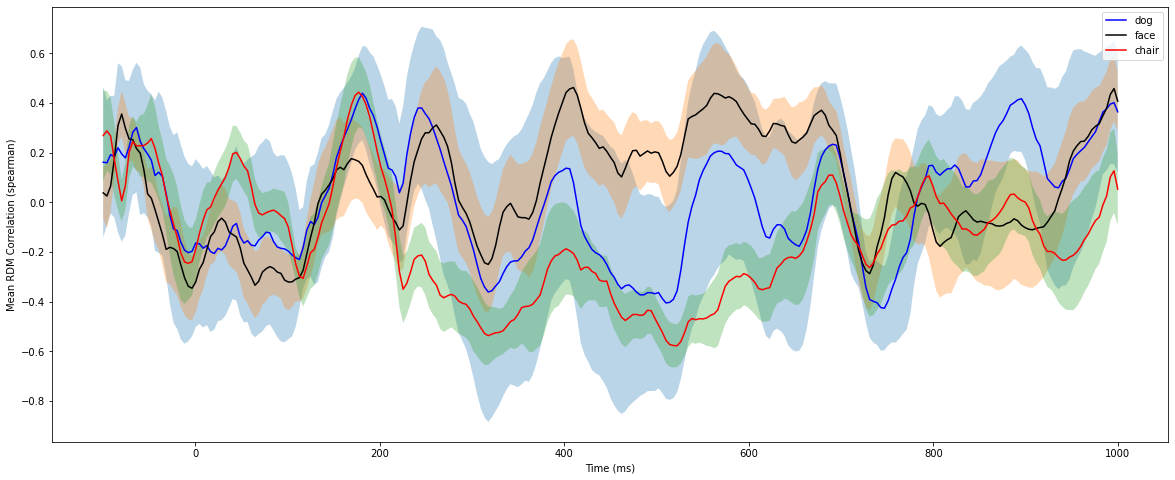

In [140]:
plt.figure(figsize=(20, 8))

plt.plot(np.linspace(-100, 1000, 275), MRSA_dog, 'b-' , label = 'dog')
plt.fill_between(np.linspace(-100, 1000, 275), con_dog_minus,con_dog_plus, alpha= 0.3)

plt.plot(np.linspace(-100, 1000, 275), MRSA_face, 'k-' , label= 'face')
plt.fill_between(np.linspace(-100, 1000, 275), con_face_minus,con_face_plus, alpha= 0.3)

plt.plot(np.linspace(-100, 1000, 275), MRSA_chair, 'r-' , label = 'chair')
plt.fill_between(np.linspace(-100, 1000, 275), con_chair_minus,con_chair_plus, alpha= 0.3)
plt.xlabel("Time (ms)")
plt.ylabel("Mean RDM Correlation (spearman)")
plt.legend()
plt.show()

In [85]:
from statsmodels.tsa.stattools import adfuller


def adf_test(timeseries):
    #print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    """dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)"""
    return dftest
    
result0 = adf_test(lfp_time)

In [89]:
flag = 0
for i in range(lfp_data[0].shape[1]):
    lfp_time0 = lfp_data[0,:,i]
    results = adf_test(lfp_time0)
    if results[1] > 0.05:
        flag =1
flag

0

In [87]:
flag = 0
for i in range(lfp_data[1].shape[1]):
    lfp_time1 = lfp_data[1,:,i]
    results = adf_test(lfp_time1)
    if results[1] > 0.05:
        flag =1
flag

0